En este notebook vamos a proponer algunos ejercicios sobre series temporales utilizando uno de los datasets que ya has visto a lo largo del bootcamp. 




# Beijing Multi-Site [Air Quality Data](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data)

El primer paso es descargarnos los datos y cargarlos en un dataframe de Pandas

In [42]:
import pandas as pd
import os
from fbprophet import Prophet
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# Movemos el directorio activo a una nueva localización para este dataset
## Retrocedemos un nivel
%cd ..
## Creamos carpeta
!mkdir /content/air_quality_dataset
## Movemos directorio activo
%cd /content/air_quality_dataset
# Descargamos fichero comprimido
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip
# Descargamos el fichero que contiene los datos a nuestro directorio activo
!unzip PRSA2017_Data_20130301-20170228.zip
# Nos movemos a la carpeta que contenía el zip
%cd PRSA_Data_20130301-20170228

# Juntamos todos los ficheros en un solo dataframe
df = pd.concat([pd.read_csv(elem) for elem in os.listdir()]).reset_index(drop=True)

/content/air_quality_dataset
y
mkdir: cannot create directory ‘/content/air_quality_dataset’: File exists
/content/air_quality_dataset
y
--2022-07-10 09:34:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7959991 (7.6M) [application/x-httpd-php]
Saving to: ‘PRSA2017_Data_20130301-20170228.zip.2’

          PRSA2017_   0%[                    ]       0  --.-KB/s               y
y
PRSA2017_Data_20130 100%[===================>]   7.59M  --.-KB/s    in 0.1s    

2022-07-10 09:34:29 (61.9 MB/s) - ‘PRSA2017_Data_20130301-20170228.zip.2’ saved [7959991/7959991]

Archive:  PRSA2017_Data_20130301-20170228.zip
replace PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

In [6]:
# vamos a empezar a hacer un poco de exploración de los datos, empezando por ver las primeras filas de nuestros datos para hacernos 
# una idea de lo que contienen
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,3.0,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,E,0.5,Changping
1,2,2013,3,1,1,3.0,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Changping
2,3,2013,3,1,2,3.0,3.0,22.0,13.0,400.0,74.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Changping
3,4,2013,3,1,3,3.0,6.0,12.0,8.0,300.0,81.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Changping
4,5,2013,3,1,4,3.0,3.0,14.0,8.0,300.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Changping


In [7]:
# Luego miramos la información que nos ofrece Pandas sobre los datos 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


Podemos ver que hay algunas columnas que tienen valores vacíos, como por ejemplo NO2, CO, O3, etc.... Esas columnas son candidatas a que vayamos aplicando algunas de las técnicas que hemos visto para lidiar con esos valores vacíos. Dado que ya has trabajado con estos datos antes, ¡no dudes en utilizar todas aquellas funciones que hayas desarrollado antes para poder limpiar y preparar estos datos!  

In [14]:
# ¿Cuantas estaciones diferentes tenemos en nuestros datos? 
df['station'].unique()

array(['Changping', 'Nongzhanguan', 'Tiantan', 'Wanshouxigong', 'Huairou',
       'Gucheng', 'Guanyuan', 'Wanliu', 'Shunyi', 'Dongsi', 'Dingling',
       'Aotizhongxin'], dtype=object)

Vamos a centrar esta primera parte del ejercicio en el comportamiento en *Changping*, pero más adelante podemos expandir nuestro análisis a otras estaciones. 

Vamos a empezar por un ejercicio sencillo en el que busquemos predecir la evolución en el próximo mes de la medida de PM10 en la estación de Changping utilizando el modelo de FBProphet que hemos visto en la teoría. 

In [19]:
#Vamos a seleccionar las columnas que nos interesan
df_pm10_changping = df[df['station']=='Changping'][['year','month', 'day', 'hour', 'PM10']]

In [21]:
# miramos de nuevo la información que nos da Pandas sobre nuestros datos
df_pm10_changping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35064 entries, 0 to 35063
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    35064 non-null  int64  
 1   month   35064 non-null  int64  
 2   day     35064 non-null  int64  
 3   hour    35064 non-null  int64  
 4   PM10    34482 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 1.6 MB


In [24]:
# Podemos ver que la variable PM10 tiene 582 registros vacíos que debemos corregir antes de crear nuestro modelo
# en este caso vamos a optar por imputar esos valores con la media de los valores que sí que tenemos
df_pm10_changping['PM10'].fillna(df_pm10_changping['PM10'].mean(),inplace=True)

In [27]:
# Tenemos nuestra fecha separada en cuatro columnas (año, mes, dia y hora), pero para poder trabajar con FBProphet
# debemos consolidar nuestra fecha en una única columna. 
df_pm10_changping['date'] = pd.to_datetime(df_pm10_changping[['year','month', 'day','hour']])

In [30]:
# Ahora que tenemos la columna que representa la fecha, nos sobran las columnas individuales para el año, mes, dia y hora
# Vamos a eliminarlas
df_pm10_changping = df_pm10_changping.drop(['year','month','day','hour'], axis=1)

In [32]:
# Recuerda que para poder utilizar el modelo de FBProphet, las columnas de nuestro dataframe deben tener unos nombres 
# concretos, si no fallará. Vamos a preparar nuestras columnas
df_pm10_changping['y'] = df_pm10_changping['PM10']
df_pm10_changping['ds'] = df_pm10_changping['date']
df_pm10_changping = df_pm10_changping.drop(['date','PM10'],axis=1)

In [33]:
# creamos nuestro modelo de FBProphet
fbprophet = Prophet()

In [34]:
# vamos a pasarle los datos para que se vaya entrenando
fbprophet.fit(df_pm10_changping)

In [36]:
# FBProphet trabaja por defecto con periodos de días pero nuestros datos se encuentran muestreados por horas, 
# por lo que tenemos que definir explícitamente que nuestros datos tienen ese muestreo a la hora de pedirle al modelo
# que genere predicciones a futuro
future = fbprophet.make_future_dataframe(periods=720, freq='H') # Le pedimos 720 periodos a futuro,lo cual equivale a un mes (24 horas * 30 dias)

In [37]:
# Vamos a crear las predicciones de la evolución de nuestra muestra
predictions = fbprophet.predict(future)

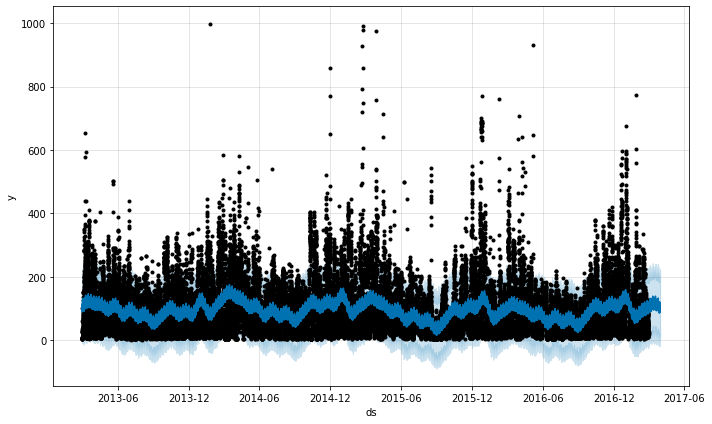

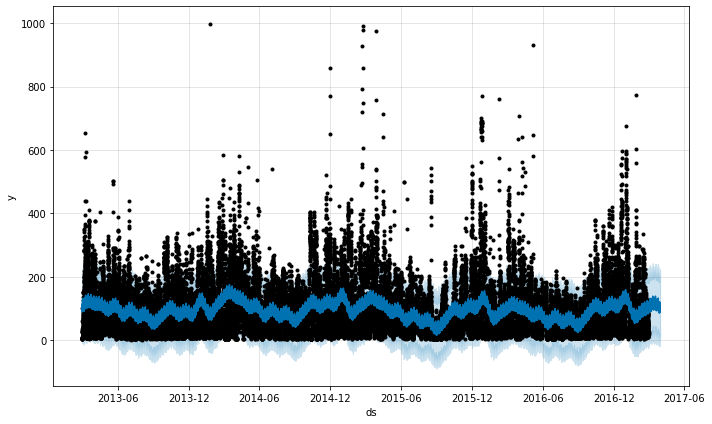

In [43]:
# Y finalmente vamos a visualizar esas predicciones que nos ha generado el modelo
fbprophet.plot(predictions)

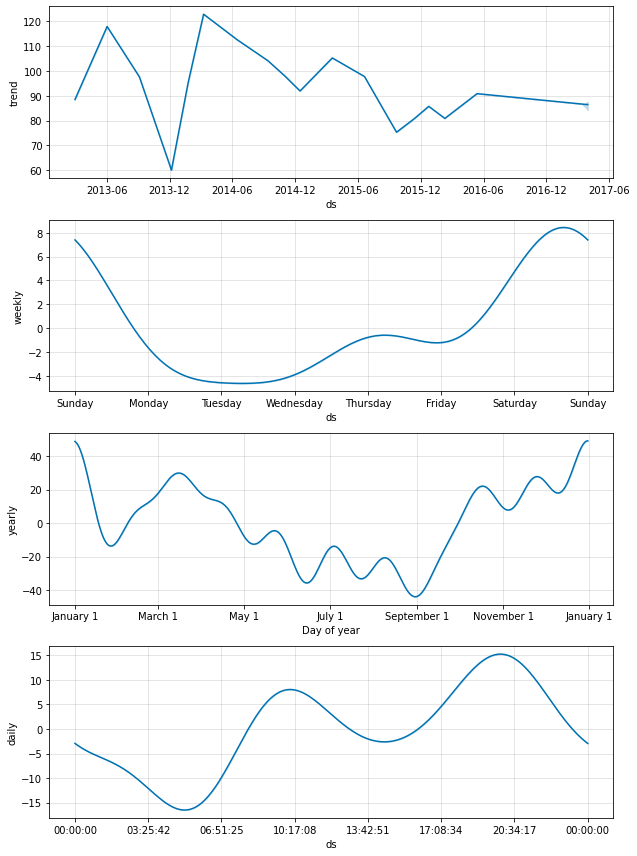

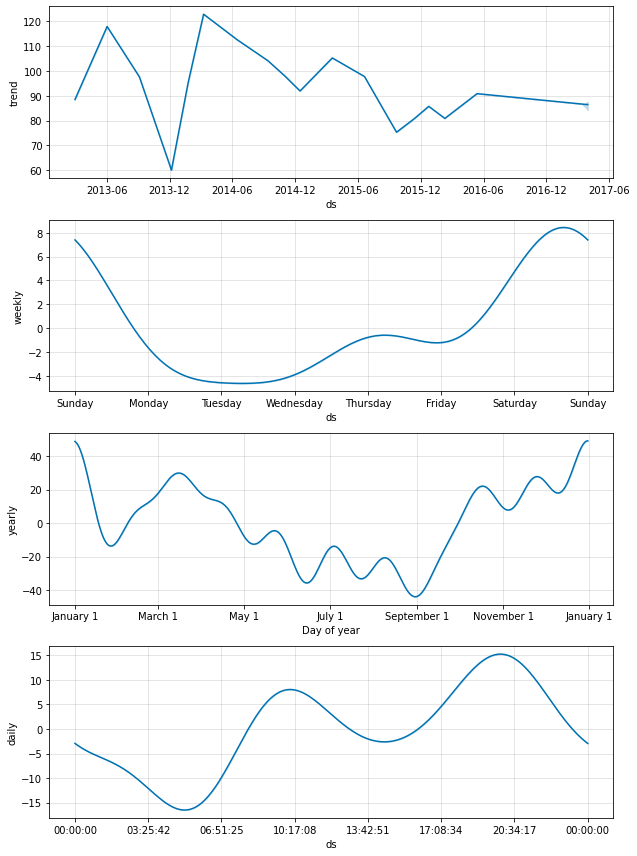

In [41]:
# y vamos a ver también los componentes que nos proporciona FBProphet
fbprophet.plot_components(predictions)

Los resultados de la predicción del modelo con el enfoque más sencillo no es muy buena puesto que los datos no se ajustan mucho a la línea de la predicción que está generando el modelo. 

¿Qué podríamos hacer para mejorar la predicción del modelo? Propón tus ideas y discútelas con tus compañeros


In [44]:
#vamos a optar por buscar la versión logarítmica de nuestros datos y entrenar el modelo sobre esos datos transformados para ver si conseguimos mejores resultados
df_pm10_changping['y'] = np.log(df_pm10_changping['y'])

In [45]:
# Creamos una nueva instancia de nuestro modelo y lo entrenamos con los datos transformados
fbprophet_log= Prophet().fit(df_pm10_changping)


In [46]:
future_log = fbprophet_log.make_future_dataframe(periods=720, freq='H')

In [47]:
predictions_log = fbprophet_log.predict(future_log)

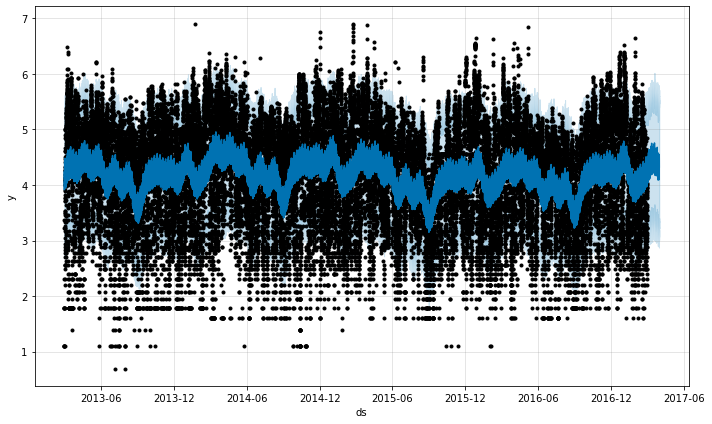

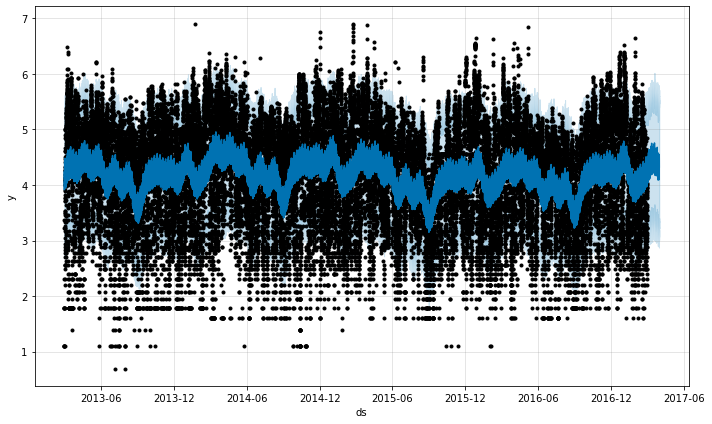

In [49]:
fbprophet_log.plot(predictions_log)

Sin ser aún perfecta, nuesta predicción se ajusta mejor ahora al comportamiento de los datos comparado con nuestro primer intento.

¿Cómo crees que podríamos seguir mejorando las predicciones de nuestro modelo?  Piensa en la posibilidad de incluir fechas que presenten comportamientos alejados del comportamiento habitual (outliers) y la posibilidad de incluirlos en el modelo utilizando el parámetro de holidays. 

## Otros enfoques que puedes explorar

- ¿Podríamos utilizar otro modelo como ARIMA para intentar generar mejores predicciones? Recuerda que ARIMA funciona con datos que no presenten estacionariedad y si los datos presentan ese comportamiento tienes que tratárlos para eliminar ese componente

- A la hora de tratar los nulos hemos optado por un método para imputar esos valores. ¿Puede una técnica diferente proporcionarnos otros resultados?

- ¿Cómo se comparan los resultados de la estación de Changping con el resto de estaciones? Prueba a realizar predicciones para cada una de las estaciones y compara los resultados por si puedes encontrar algún comportamiento interesante. 

- Hasta ahora hemos analizado solo el comportamiento de la columna de PM10. También tenemos en nuestro dataset otra columna llamada PM2.5 que mide un tipo relacionado de partículas en el aire. ¿Presentan las predicciones de esa columna un comportamiento similar a las que hemos visto para la columna de PM10? 

- Hasta ahora hemos optado solo por utilizar la variable que queríamos predecir a la hora de entrenar el modelo. Eso es lo que se conoce como una serie temporal univariada. Pero en el mundo real, tenemos múltiples otras variables que pueden afectar al comportamiento de nuestra variable objetivo. Si tenemos en cuenta varias variables a la hora de entrenar nuestra serie temporal, entonces tenemos una serie temporal multivariada. Con FBProphet, podemos entrenar series temporales multivariadas incluyendo el resto de variables en el dataframe que pasamos al modelo y especificando en la definición del modelo que tiene que añadir esas variables durante el proceso de entrenamiento. Por ejemplo:
```python
m = Prophet()
m.add_regressor('variable_extra1')
m.add_regressor('variable_extra2')
m.fit(df)
```
Teniendo esto en cuenta, ¿crees que se podría mejorar la predicción para la columna PM10 si utilizamos también las columnas de temperatura (TEMP), presión atmosférica (PRES) y lluvia (RAIN) durante el entrenamiento?
